# Scalar Amplitudes with AmpliTools
### Compute the 4- and 5-point tree amplitudes of a scalar QFT in arbitrary spacetime dimension with an arbitary spectrum of (massive or massless) states.
Given arbitrary (local) interaction operators specified by flavor tensors and polynomials of Mandelstam invariants, AmpliTools
1. computes the relevant (tree) diagram topologies,
2. constructs their symbolic expressions from Feynman rules,
3. reduces these expressions modulo symmetries of the interaction flavor tensors,
4. reduces them modulo the on-shell and momentum-conservation constraints, and finally
5. expresses the resulting amplitude as a rational function over a minimal kinematic basis with one free flavor index for each external leg.

- The amplitudes of particular theories are obtained by substituting explicit expressions for scalar masses and interaction flavor tensors (Wilson coefficients) and fixing the free flavor indices.
- However, one can also study general properties of scalar theories with local interactions using the expressions from AmpliTools.
- For example, by constructing the leading terms of the Laurent series of the general 4- and 5-point scalar amplitudes and demanding they vanish in the IR (zero-energy) limit, one obtains algebraic constraints on the cubic and quartic interaction flavor tensors which are necessary and sufficient for the theory to exhibit an Adler zero (see https://arxiv.org/abs/2012.13076).

### Imports/Path

In [1]:
import sys
TFDirectory = "../src"
sys.path.append(TFDirectory)

import os
import psutil
from tqdm import tqdm
import networkx as nx
import sympy
from sympy import symbols,I
sympy.init_printing()
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time
import math

from interface import Interface, FeynmanRules, TensorSymmetries
from kinematic_basis import Basis
from mrational import MRational
from mathematica_conversion import mrational_to_file
from permutation_tools import symmetric_partition_permutations
from signed_permutations import SignedPermutationGroup, SignedPermutation
from tensor_tools import tensor_index_replacement
from graph import compute_tree_amplitude

### SymPy Variables

In [2]:
#Max number of external legs
nmax = 6

#Declare sympy variables.
momentum_symbols = [symbols('p'+str(i)) for i in range(1,nmax+1)]
polarization_symbols = [symbols('e'+str(i)) for i in range(1,nmax+1)]
mass_symbols = [symbols('m_'+str(i)) for i in range(1,nmax+1)]
mass_tensors = [symbols('m_{f'+str(i)+'}') for i in range(1,nmax+1)]
m_phi = symbols('m_\phi')

### Flavor Tensors and Symmetries
- Each flavor tensor is associated with three pieces of data:
1. a string "head_{indices}", e.g. "A_{f1f2f3}",
2. a sympy variable, and
3. a TensorSymmetry object, which encodes the index permutation symmetries, and associated signs.

- register_symmetry() takes tensor heads, generators, and generator signs as arguments.
- Here, "sign" does not refer to the sign of the permutation in the group theoretic sense,but rather to the phase induced by a particular permutation of the states. 
- Fermionic symmetries will contribue such phases, but we'll work with bosons here.
- Indices of the form f# denote "free", or external-leg indices. Indices b#, on the other hand, denote "bound" (internal line) indices.

In [3]:
#Define flavor/color tensors and specify their symmetries.
tensym = TensorSymmetries()
ID_f1f2 = symbols('ID_{f1f2}')
tensym.register_symmetry("ID",[([2,1],1),])
A_f1f2f3 = symbols('A_{f1f2f3}')
tensym.register_symmetry("A",[([2,1,3],1),([1,3,2],1)])
B_f1f2f3f4 = symbols('B_{f1f2f3f4}')
tensym.register_symmetry("B",[([2,1,3,4],1),([1,3,2,4],1),([1,2,4,3],1)])

flavor_tensors = [ID_f1f2, A_f1f2f3, B_f1f2f3f4]
coefficient_symbols = mass_symbols + mass_tensors + [m_phi,] + flavor_tensors
coefficient_display_map = {}

### Constructing the Interface
- The Interface class provides a UI geared toward the Jupyter notebook.
- Primarily, the interface converts between various representations of propagators, interactions, and amplitudes.
- It also provides LaTeX formatting for expressions and graph drawing for Feynman diagrams.

In [4]:
#Initialize the interface for input/display of amplitude data.
io = Interface(momentum_symbols,polarization_symbols,coefficient_symbols,coefficient_display_map)

#Define convenience functions.
def mring(expr):
    return io.expr_to_mring(expr)
def mrat(num,den):
    return io.expr_to_mrational(num,den)
def mprint(malg):
    io.display(malg)

### Aside: MRing and MRational
- We will see that AmpliTools doesn't deal directly with SymPy expressions. 
- Much of the heavy lifting in these calculations isn't rational algebra per se, but reductions of rational expressions to canonical form under flavor symmetry orbits and kinematic constraints.
- To smoothly integrate these operations with the usual arithmetic on a rational field, SymPy polynomials are wrapped in MRing objects ("Mandelstam Ring"), which in turn are wrapped in MRational objects ("Mandelstam Rational").
- MRing objects are elements of a polynomial ring generated by products of Mandelstam invariants and flavor tensors, with coefficients in the Gaussian rationals.
- Various MRing methods implement flavor and kinematic reductions, but all the expected ring operators have been overloaded, so MRings are "transparently polynomial".
- MRational objects are elements of the fraction field of MRing. AmpliTools represents tree amplitudes as MRationals. In the same spirit as MRing, MRational provides methods for reduction and manipulation of flavor and kinematics, while overloading the expected field operators, so MRationals are "transparently rational".

### Interaction operators and Feynman Rules
- Lagrangian operators involve flavor tensors and momenta/polarizations (in the spin 1+ case).
- The FeynmanRules class takes a minimal kinematic basis and the TensorSymmetries object at initialization.
- Its method register_propagator/register_interaction then converts an expression containing momenta, polarizations, and flavor tensors into a vertex or propagator.
- This amounts to symmetrizing the fields and reducing the result using flavor symmetries and momentum conservation constraints.
- We won't worry about derivative coupling or polarizations in this example.

### Example: Cubic Operator
Below, the cubic interaction is determined by:
1. The MRing expr_A, which contains the flavor and derivative (kinematic) structure of the operator (though there are no derivative couplings in this example),
2. the "valence list" ['phi','phi','phi'], encoding the field operators which comprise the interaction operator (all fields are scalars in this example, but when interactions couple particles of different spins, the valence lists keep contractions straight.
3. the highest spin among the fields in the valence list (max_spin=0 here),
4. the perturbative order of the interaction (relative to the free lagrangian), and finally
5. an interaction label which is displayed on top of the corresponding vertices when drawing Feynman diagrams.

In [5]:
#Construct Feynman rules for each propagator and interaction operator.
feynrules = FeynmanRules(tensym.tensor_symmetries,io)

#Register Propagators
p1,p2 = symbols('p1 p2')
m_f1 = symbols('m_{f1}')
phiprop = mrat(mring(I*ID_f1f2),{mring(p1*p1-m_f1**2):1})
feynrules.register_propagator(phiprop,"phi")

#Register interactions
expr_A = mring(A_f1f2f3)
feynrules.register_interaction(expr_A,['phi','phi','phi'],0,1,"A")

expr_B = mring(B_f1f2f3f4)
feynrules.register_interaction(expr_B,['phi','phi','phi','phi'],0,2,"B")

## 4-Point Tree Amplitude
### Constructing the Amplitude
- Assuming a pure-scalar scattering process, the external legs are tagged accordingly.
- Finally, calculation begins with a call to compute_tree_amplitude() from the graph module.
- Given the Feynman rules and symmetries prepared above, AmpliTools performs the first three steps of the calculation: identifying diagram topologies, building symbolic expressions by dressing those topologies with the Feynman rules, and reducing the resulting expression modulo flavor tensor symmetries (also known as "index canonization").
- The final two steps: reduction mod kinematic constraints and output, are done separately in the next cell. It is useful to separate the kinematic manipulations so one has the option of working with expressions for the amplitudes lifted to off-shell kinematic space.

IN CTA
BEFORE compute_contractions
IN CC
Before SGDFS
After SGDFS
Before IC
IN IC0
IN IC
After IC


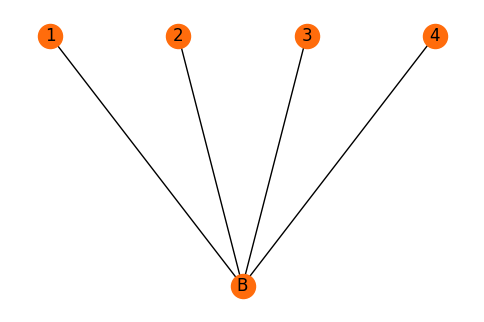

isomaps:   {{1: 1, 2: 2, 3: 3, 4: 4}: 1}


collect Terms: 100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00, 605.50it/s]

done compute_contractions




BEFORE compute_contractions
IN CC
Before SGDFS
After SGDFS
Before IC
IN IC0
IN IC


After IC


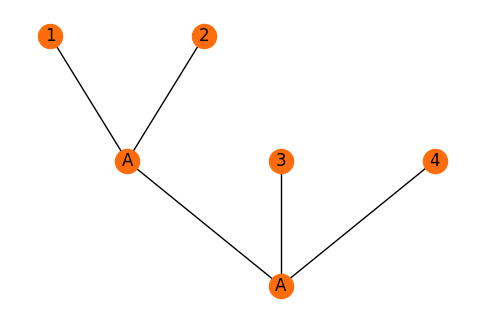

isomaps:   {{1: 1, 2: 2, 3: 3, 4: 4}: 2, {1: 4, 2: 2, 3: 1, 4: 3}: 2, {1: 3, 2: 2, 3: 1, 4: 4}: 2}


collect Terms: 100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00, 491.31it/s]


done compute_contractions






In [6]:
npoint = 4
external_legs = ['phi' for i in range(0,npoint)]

amplitude = compute_tree_amplitude(feynrules.interactions,feynrules.propagators,external_legs,tensym.tensor_symmetries)

In [7]:
mprint(amplitude)

<IPython.core.display.Math object>

### Kinematic Reductions
- We reduce the amplitude MRational by kinematic constraints and send Mandelstam invariants of the form $p_i \cdot p_i$ to SymPy symbols $m^2_i$.
- Mass symbols $m^2_i$ are converted to the same f#/b# notation ($m^2_{fi}$ or $m^2_{bi}$) as the flavor tensors by group_masses()
- Finally, the amplitude is typeset and displayed.

In [8]:
#Construct kinematic basis for scattering of spin-0 particles in arbitary spacetime dimension
npoint = 4
spin = 0
basis = Basis(spin,npoint)

#Reduce and simplify expression using on-shell and momentum conservation constraints.
amplitude_os = amplitude.onshell(basis).eject_masses(basis)

#Finally, associate propagating and external masses with their corresponding flavor indices.
#Indices (f#) are free (external leg labels).
#Indices (b#) are bound (propagator leg labels). 
for i in range(npoint):
    amplitude_os = amplitude_os.group_masses({(mass_symbols[i],):mass_tensors[i]},basis)

mprint(amplitude_os)

<IPython.core.display.Math object>

- N.B. There is an implicit summation symbol before each rational term running over all bound indices present in the term. In particular, we are NOT using Einstein summation convention, which would suggest summation of repeated flavor indicesin the numerator factors by themselves (leaving a hanging bound index in the denominator).
- The first term above contains the contribution of the four-point contact operator.
- The final three terms are the s,t,u channel permutations of the two-trivalent-vertex tree topology. Summation of each rational term over the bound index simply includes diagrams for each scalar flavor that could propagate between the two vertices.

In [9]:
## 5-Point Tree Amplitude

IN CTA
BEFORE compute_contractions
IN CC
Before SGDFS
After SGDFS
Before IC
IN IC0
IN IC
After IC


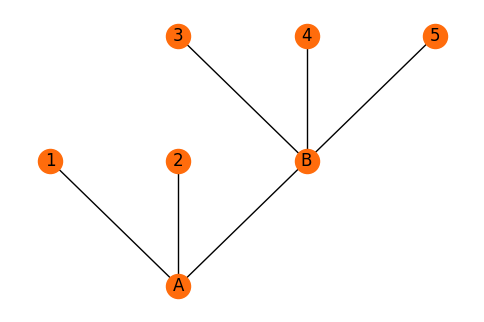

isomaps:   {{1: 1, 2: 2, 3: 3, 4: 4, 5: 5}: 1, {1: 1, 2: 3, 3: 2, 4: 4, 5: 5}: 1, {1: 1, 2: 4, 3: 3, 4: 2, 5: 5}: 1, {1: 1, 2: 5, 3: 3, 4: 2, 5: 4}: 1, {1: 3, 2: 2, 3: 1, 4: 4, 5: 5}: 1, {1: 4, 2: 2, 3: 3, 4: 1, 5: 5}: 1, {1: 5, 2: 2, 3: 3, 4: 1, 5: 4}: 1, {1: 4, 2: 3, 3: 2, 4: 5, 5: 1}: 1, {1: 5, 2: 3, 3: 2, 4: 4, 5: 1}: 1, {1: 4, 2: 5, 3: 1, 4: 2, 5: 3}: 1}


collect Terms: 100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00, 327.94it/s]


done compute_contractions




BEFORE compute_contractions
IN CC
Before SGDFS
After SGDFS
Before IC
IN IC0
IN IC
After IC


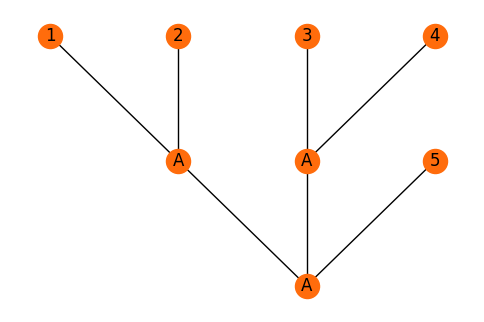

isomaps:   {{1: 3, 2: 2, 3: 5, 4: 4, 5: 1}: 6, {1: 4, 2: 2, 3: 3, 4: 5, 5: 1}: 6, {1: 5, 2: 2, 3: 3, 4: 4, 5: 1}: 6, {1: 1, 2: 3, 3: 5, 4: 4, 5: 2}: 6, {1: 1, 2: 4, 3: 3, 4: 5, 5: 2}: 6, {1: 1, 2: 5, 3: 3, 4: 4, 5: 2}: 6, {1: 1, 2: 2, 3: 5, 4: 4, 5: 3}: 6, {1: 5, 2: 2, 3: 1, 4: 4, 5: 3}: 3, {1: 4, 2: 2, 3: 1, 4: 5, 5: 3}: 3, {1: 1, 2: 5, 3: 4, 4: 2, 5: 3}: 3, {1: 1, 2: 4, 3: 5, 4: 2, 5: 3}: 3, {1: 1, 2: 2, 3: 3, 4: 5, 5: 4}: 6, {1: 5, 2: 2, 3: 1, 4: 3, 5: 4}: 3, {1: 3, 2: 2, 3: 1, 4: 5, 5: 4}: 3, {1: 1, 2: 5, 3: 3, 4: 2, 5: 4}: 3, {1: 1, 2: 3, 3: 5, 4: 2, 5: 4}: 3, {1: 1, 2: 2, 3: 3, 4: 4, 5: 5}: 6, {1: 4, 2: 2, 3: 1, 4: 3, 5: 5}: 3, {1: 3, 2: 2, 3: 1, 4: 4, 5: 5}: 3, {1: 1, 2: 4, 3: 3, 4: 2, 5: 5}: 3, {1: 1, 2: 3, 3: 4, 4: 2, 5: 5}: 3}


collect Terms: 100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00, 218.09it/s]


done compute_contractions






In [10]:
npoint = 5
external_legs = ['phi' for i in range(0,npoint)]

amplitude = compute_tree_amplitude(feynrules.interactions,feynrules.propagators,external_legs,tensym.tensor_symmetries)

In [11]:
mprint(amplitude)

<IPython.core.display.Math object>

In [12]:
npoint = 5
spin = 0
basis = Basis(spin,npoint)

for _ in tqdm([1]):
    amplitude_os = amplitude.onshell(basis).eject_masses(basis)
    for i in range(npoint):
        amplitude_os = amplitude_os.group_masses({(mass_symbols[i],):mass_tensors[i]},basis)

mprint(amplitude_os)

100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.73s/it]


<IPython.core.display.Math object>

IN CTA
BEFORE compute_contractions
IN CC
Before SGDFS
After SGDFS
Before IC
IN IC0
IN IC
After IC


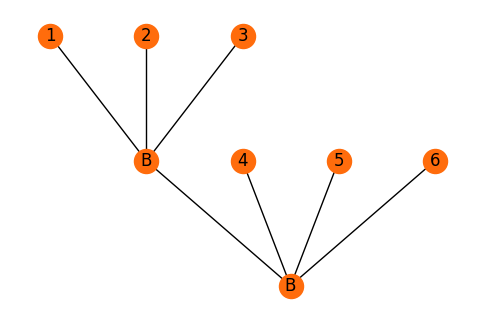

isomaps:   {{1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}: 2, {1: 4, 2: 2, 3: 1, 4: 3, 5: 5, 6: 6}: 2, {1: 5, 2: 2, 3: 1, 4: 4, 5: 3, 6: 6}: 2, {1: 6, 2: 2, 3: 1, 4: 4, 5: 3, 6: 5}: 2, {1: 4, 2: 1, 3: 3, 4: 2, 5: 5, 6: 6}: 2, {1: 5, 2: 1, 3: 3, 4: 4, 5: 2, 6: 6}: 2, {1: 6, 2: 1, 3: 3, 4: 4, 5: 2, 6: 5}: 2, {1: 6, 2: 2, 3: 3, 4: 4, 5: 1, 6: 5}: 2, {1: 5, 2: 2, 3: 3, 4: 4, 5: 1, 6: 6}: 2, {1: 4, 2: 2, 3: 3, 4: 1, 5: 5, 6: 6}: 2}


collect Terms: 100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00, 336.49it/s]


done compute_contractions




BEFORE compute_contractions
IN CC
Before SGDFS
After SGDFS
Before IC
IN IC0
IN IC
After IC


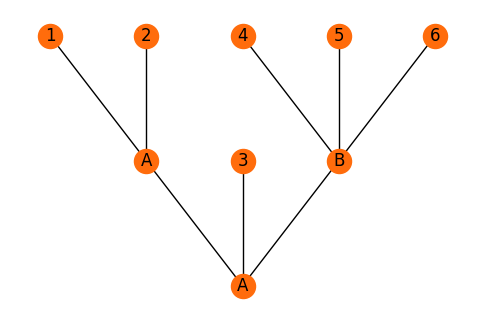

isomaps:   {{1: 3, 2: 2, 3: 1, 4: 4, 5: 5, 6: 6}: 2, {1: 4, 2: 2, 3: 1, 4: 3, 5: 5, 6: 6}: 2, {1: 5, 2: 2, 3: 1, 4: 4, 5: 3, 6: 6}: 2, {1: 6, 2: 2, 3: 1, 4: 4, 5: 3, 6: 5}: 2, {1: 4, 2: 3, 3: 1, 4: 6, 5: 5, 6: 2}: 2, {1: 5, 2: 3, 3: 1, 4: 4, 5: 6, 6: 2}: 2, {1: 6, 2: 3, 3: 1, 4: 4, 5: 5, 6: 2}: 2, {1: 5, 2: 4, 3: 1, 4: 3, 5: 2, 6: 6}: 2, {1: 6, 2: 4, 3: 1, 4: 3, 5: 2, 6: 5}: 2, {1: 5, 2: 6, 3: 1, 4: 2, 5: 3, 6: 4}: 2, {1: 1, 2: 3, 3: 2, 4: 4, 5: 5, 6: 6}: 2, {1: 1, 2: 4, 3: 2, 4: 3, 5: 5, 6: 6}: 2, {1: 1, 2: 5, 3: 2, 4: 4, 5: 3, 6: 6}: 2, {1: 1, 2: 6, 3: 2, 4: 4, 5: 3, 6: 5}: 2, {1: 3, 2: 4, 3: 2, 4: 6, 5: 5, 6: 1}: 2, {1: 3, 2: 5, 3: 2, 4: 4, 5: 6, 6: 1}: 2, {1: 3, 2: 6, 3: 2, 4: 4, 5: 5, 6: 1}: 2, {1: 5, 2: 4, 3: 2, 4: 3, 5: 1, 6: 6}: 2, {1: 6, 2: 4, 3: 2, 4: 3, 5: 1, 6: 5}: 2, {1: 5, 2: 6, 3: 2, 4: 1, 5: 3, 6: 4}: 2, {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}: 2, {1: 1, 2: 4, 3: 3, 4: 2, 5: 5, 6: 6}: 2, {1: 1, 2: 5, 3: 3, 4: 4, 5: 2, 6: 6}: 2, {1: 1, 2: 6, 3: 3, 4: 4, 5: 2, 6: 5}: 2, {1: 

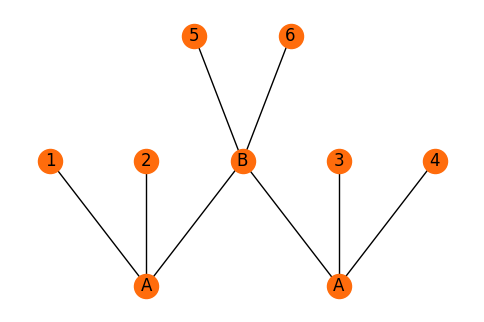

isomaps:   {{1: 5, 2: 6, 3: 1, 4: 2, 5: 3, 6: 4}: 2, {1: 2, 2: 1, 3: 4, 4: 6, 5: 3, 6: 5}: 1, {1: 2, 2: 1, 3: 4, 4: 5, 5: 3, 6: 6}: 1, {1: 2, 2: 1, 3: 6, 4: 3, 5: 4, 6: 5}: 2, {1: 2, 2: 1, 3: 5, 4: 3, 5: 4, 6: 6}: 2, {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}: 2, {1: 6, 2: 5, 3: 3, 4: 1, 5: 2, 6: 4}: 2, {1: 6, 2: 4, 3: 1, 4: 3, 5: 2, 6: 5}: 1, {1: 5, 2: 4, 3: 1, 4: 3, 5: 2, 6: 6}: 1, {1: 3, 2: 1, 3: 2, 4: 6, 5: 4, 6: 5}: 2, {1: 3, 2: 1, 3: 2, 4: 5, 5: 4, 6: 6}: 2, {1: 4, 2: 2, 3: 1, 4: 3, 5: 5, 6: 6}: 1, {1: 6, 2: 5, 3: 4, 4: 1, 5: 2, 6: 3}: 2, {1: 1, 2: 4, 3: 6, 4: 3, 5: 2, 6: 5}: 1, {1: 1, 2: 4, 3: 5, 4: 3, 5: 2, 6: 6}: 1, {1: 1, 2: 4, 3: 6, 4: 2, 5: 3, 6: 5}: 1, {1: 1, 2: 4, 3: 5, 4: 2, 5: 3, 6: 6}: 1, {1: 3, 2: 2, 3: 1, 4: 4, 5: 5, 6: 6}: 1, {1: 6, 2: 4, 3: 1, 4: 5, 5: 2, 6: 3}: 1, {1: 1, 2: 5, 3: 6, 4: 3, 5: 2, 6: 4}: 1, {1: 1, 2: 5, 3: 4, 4: 3, 5: 2, 6: 6}: 1, {1: 1, 2: 5, 3: 6, 4: 2, 5: 3, 6: 4}: 1, {1: 1, 2: 5, 3: 4, 4: 2, 5: 3, 6: 6}: 1, {1: 5, 2: 1, 3: 2, 4: 3, 5: 4, 6: 6}: 2, {1: 

collect Terms: 100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00, 162.00it/s]


done compute_contractions




BEFORE compute_contractions
IN CC
Before SGDFS
After SGDFS
Before IC
IN IC0
IN IC
After IC


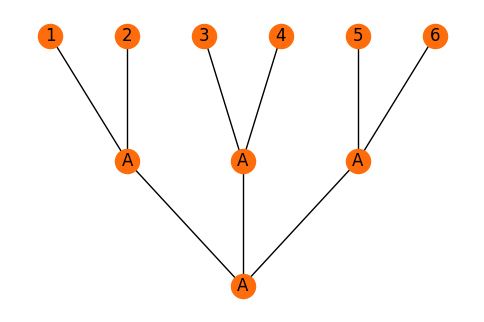

isomaps:   {{1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}: 24, {1: 1, 2: 2, 3: 6, 4: 4, 5: 3, 6: 5}: 8, {1: 1, 2: 2, 3: 5, 4: 4, 5: 3, 6: 6}: 8, {1: 1, 2: 2, 3: 3, 4: 6, 5: 4, 6: 5}: 8, {1: 1, 2: 2, 3: 3, 4: 5, 5: 4, 6: 6}: 8, {1: 1, 2: 3, 3: 2, 4: 4, 5: 5, 6: 6}: 8, {1: 1, 2: 3, 3: 6, 4: 4, 5: 2, 6: 5}: 8, {1: 1, 2: 3, 3: 5, 4: 4, 5: 2, 6: 6}: 8, {1: 1, 2: 3, 3: 6, 4: 2, 5: 5, 6: 4}: 4, {1: 1, 2: 3, 3: 5, 4: 2, 5: 6, 6: 4}: 4, {1: 1, 2: 3, 3: 5, 4: 6, 5: 2, 6: 4}: 4, {1: 1, 2: 4, 3: 2, 4: 3, 5: 5, 6: 6}: 8, {1: 1, 2: 4, 3: 3, 4: 6, 5: 2, 6: 5}: 8, {1: 1, 2: 4, 3: 3, 4: 5, 5: 2, 6: 6}: 8, {1: 1, 2: 4, 3: 2, 4: 6, 5: 3, 6: 5}: 4, {1: 1, 2: 4, 3: 2, 4: 5, 5: 3, 6: 6}: 4, {1: 1, 2: 4, 3: 5, 4: 6, 5: 2, 6: 3}: 4, {1: 1, 2: 5, 3: 6, 4: 4, 5: 2, 6: 3}: 8, {1: 1, 2: 5, 3: 3, 4: 6, 5: 2, 6: 4}: 8, {1: 1, 2: 5, 3: 3, 4: 4, 5: 2, 6: 6}: 8, {1: 1, 2: 5, 3: 2, 4: 6, 5: 3, 6: 4}: 4, {1: 1, 2: 5, 3: 2, 4: 4, 5: 3, 6: 6}: 4, {1: 1, 2: 5, 3: 3, 4: 2, 5: 6, 6: 4}: 4, {1: 1, 2: 6, 3: 5, 4: 4, 5: 2, 6: 3}: 8, {1:

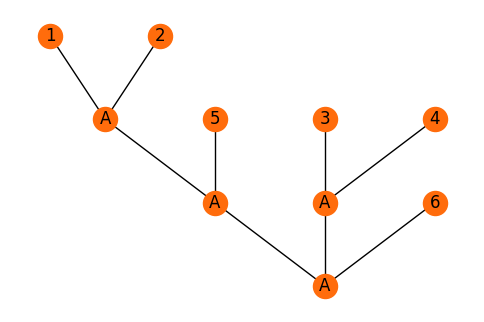

isomaps:   {{1: 3, 2: 4, 3: 5, 4: 6, 5: 1, 6: 2}: 12, {1: 3, 2: 5, 3: 6, 4: 4, 5: 1, 6: 2}: 12, {1: 3, 2: 6, 3: 5, 4: 4, 5: 1, 6: 2}: 12, {1: 4, 2: 5, 3: 3, 4: 6, 5: 1, 6: 2}: 12, {1: 4, 2: 6, 3: 3, 4: 5, 5: 1, 6: 2}: 12, {1: 5, 2: 6, 3: 3, 4: 4, 5: 1, 6: 2}: 12, {1: 6, 2: 5, 3: 4, 4: 2, 5: 3, 6: 1}: 12, {1: 5, 2: 2, 3: 6, 4: 4, 5: 1, 6: 3}: 24, {1: 6, 2: 2, 3: 5, 4: 4, 5: 1, 6: 3}: 24, {1: 6, 2: 2, 3: 5, 4: 4, 5: 3, 6: 1}: 24, {1: 5, 2: 2, 3: 6, 4: 4, 5: 3, 6: 1}: 24, {1: 4, 2: 2, 3: 5, 4: 6, 5: 3, 6: 1}: 12, {1: 6, 2: 5, 3: 3, 4: 2, 5: 4, 6: 1}: 12, {1: 5, 2: 2, 3: 3, 4: 6, 5: 1, 6: 4}: 24, {1: 6, 2: 2, 3: 3, 4: 5, 5: 1, 6: 4}: 24, {1: 6, 2: 2, 3: 3, 4: 5, 5: 4, 6: 1}: 24, {1: 5, 2: 2, 3: 3, 4: 6, 5: 4, 6: 1}: 24, {1: 3, 2: 2, 3: 5, 4: 6, 5: 4, 6: 1}: 12, {1: 3, 2: 2, 3: 6, 4: 4, 5: 1, 6: 5}: 24, {1: 4, 2: 2, 3: 3, 4: 6, 5: 1, 6: 5}: 24, {1: 6, 2: 2, 3: 3, 4: 4, 5: 1, 6: 5}: 24, {1: 6, 2: 2, 3: 3, 4: 4, 5: 5, 6: 1}: 24, {1: 4, 2: 2, 3: 3, 4: 6, 5: 5, 6: 1}: 24, {1: 3, 2: 2, 3: 6, 4: 

collect Terms: 100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00, 113.42it/s]


In [ ]:
npoint = 6
external_legs = ['phi' for i in range(0,npoint)]

amplitude = compute_tree_amplitude(feynrules.interactions,feynrules.propagators,external_legs,tensym.tensor_symmetries)